**Data Collection**

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
start_date = '2018-12-1'
end_date = '2024-12-1'
start_date , end_date

('2018-12-1', '2024-12-1')

In [3]:
df = yf.download(tickers='AAPL',start=start_date, end=end_date)
df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2018-12-03,44.131859,46.205002,46.235001,45.302502,46.115002,163210000
2018-12-04,42.190563,44.172501,45.597500,44.067501,45.237499,165377200
2018-12-06,41.720146,43.680000,43.695000,42.605000,42.939999,172393600
2018-12-07,40.232540,42.122501,43.622501,42.075001,43.372501,169126400
2018-12-10,40.497581,42.400002,42.522499,40.832500,41.250000,248104000
...,...,...,...,...,...,...
2024-11-22,229.869995,229.869995,230.720001,228.059998,228.059998,38168300
2024-11-25,232.869995,232.869995,233.250000,229.740005,231.460007,90152800


In [4]:
df.shape

(1508, 6)

In [5]:
apple_df = df.reset_index()['Close']
apple_df

Ticker,AAPL
0,46.205002
1,44.172501
2,43.680000
3,42.122501
4,42.400002
...,...
1503,229.869995
1504,232.869995
1505,235.059998
1506,234.929993


In [6]:
apple_df.rename(columns={'AAPL': 'Close'}, inplace=True)
apple_df

Ticker,Close
0,46.205002
1,44.172501
2,43.680000
3,42.122501
4,42.400002
...,...
1503,229.869995
1504,232.869995
1505,235.059998
1506,234.929993


In [7]:
apple_df.sort_index(inplace = True)

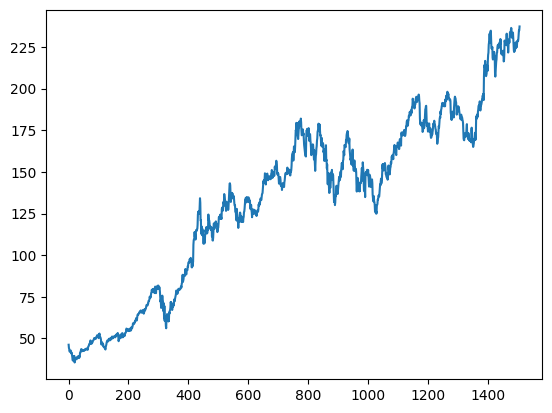

In [8]:
plt.plot(apple_df)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
apple_df=scaler.fit_transform(np.array(apple_df).reshape(-1,1))
apple_df


array([[0.05281678],
       [0.04274404],
       [0.0403033 ],
       ...,
       [0.98875024],
       [0.98810596],
       [1.        ]])

In [10]:
training_size=int(len(apple_df)*0.65)
test_size=len(apple_df)-training_size
train_data,test_data=apple_df[0:training_size,:],apple_df[training_size:len(apple_df),:1]

In [11]:
training_size,test_size

(980, 528)

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
print(X_train.shape), print(y_train.shape)

(879, 100)
(879,)


(None, None)

In [15]:
print(X_test.shape), print(ytest.shape)

(427, 100)
(427,)


(None, None)

In [16]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

**Creating and Applying LSTM MOdel**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [18]:
model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(1)
])

c:\Users\Prerana Walvekar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - loss: 0.0801 - val_loss: 0.0890
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.0165 - val_loss: 0.0077
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

**Prediction**

In [21]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [22]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

121.4625394543753

In [24]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

184.67076432121112

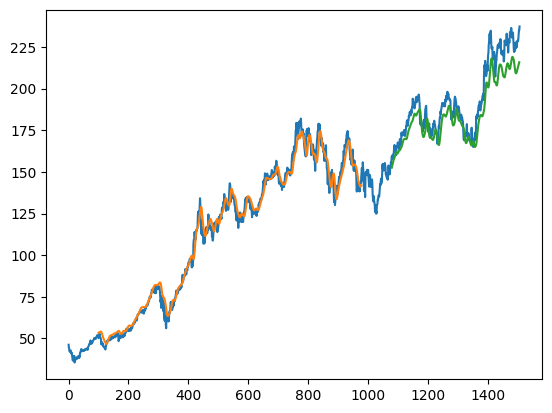

In [25]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(apple_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(apple_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(apple_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(apple_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**Calculating Accuracy**

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_train = np.sqrt(mean_squared_error(y_train, train_predict))
rmse_test = np.sqrt(mean_squared_error(ytest, test_predict))
r2_test = r2_score(ytest, test_predict)
Accuracy

print(f"RMSE (Train): {rmse_train}")
print(f"RMSE (Test): {rmse_test}")
print(f"R2 Score (Test): {r2_test}")

RMSE (Train): 121.4625394543753
RMSE (Test): 184.67076432121112
R2 Score (Test): -2963165.4518183544
